<a href="https://colab.research.google.com/github/lucevito/image/blob/main/kerasB_26_70.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, jaccard_score, confusion_matrix, f1_score
import tensorflow as tf
import os
import uuid
import glob
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras import *
import matplotlib.pyplot as plt
from keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_recall_fscore_support


encoder_filters = [256,512,1024]
decoder_filters = encoder_filters[::-1]
kernel = (2,2)
num_classes = 1
pool_size = (2, 2)

size = (32, 32)
canali_selezionati = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
input_shape = (size[0], size[1], len(canali_selezionati))
modello = 'modello.h5'

In [ ]:
train_images_path = 'Immagini_satellitari/Train/images'
train_masks_path = 'Immagini_satellitari/Train/masks'
train_images_files = glob.glob(train_images_path + '/*.npy')
train_masks_files = glob.glob(train_masks_path + '/*.npy')
train_images_batch = np.array([np.load(file) for file in train_images_files])
train_masks_batch = np.array([np.load(file) for file in train_masks_files])
train_images_batch = train_images_batch[:, :, :, canali_selezionati]
train_masks_batch = tf.expand_dims(train_masks_batch, axis=-1)

test_images_path = 'Immagini_satellitari/Test/images'
test_masks_path = 'Immagini_satellitari/Test/masks'
test_images_files = glob.glob(test_images_path + '/*.npy')
test_masks_files = glob.glob(test_masks_path + '/*.npy')
test_images_batch = np.array([np.load(file) for file in test_images_files])
test_masks_batch = np.array([np.load(file) for file in test_masks_files])
test_images_batch = test_images_batch[:, :, :, canali_selezionati]
test_masks_batch = tf.expand_dims(test_masks_batch, axis=-1)
"""
images_to_keep = []
masks_to_keep = []

for image, mask in zip(train_images_batch, train_masks_batch):
    if not np.all(mask == 0):
        images_to_keep.append(image)
        masks_to_keep.append(mask)

train_images_batch_filtered = np.array(images_to_keep)
train_masks_batch_filtered = np.array(masks_to_keep)
print(train_images_batch_filtered.shape)
#(311, 32, 32, 10)
"""

'\nimages_to_keep = []\nmasks_to_keep = []\n\nfor image, mask in zip(train_images_batch, train_masks_batch):\n    if not np.all(mask == 0):\n        images_to_keep.append(image)\n        masks_to_keep.append(mask)\n\ntrain_images_batch_filtered = np.array(images_to_keep)\ntrain_masks_batch_filtered = np.array(masks_to_keep)\nprint(train_images_batch_filtered.shape)\n#(311, 32, 32, 10)\n'

In [ ]:
def flip_left_right(input_image, input_mask):
  channels = tf.split(input_image, num_or_size_splits=10, axis=-1)
  flipped_channels = [tf.image.flip_left_right(channel) for channel in channels]
  input_image = tf.concat(flipped_channels, axis=-1)
  input_mask = tf.image.flip_left_right(input_mask)
  return input_image, input_mask

# Rotazione
def rotate_image(input_image, input_mask, angle=45):
    channels = tf.split(input_image, num_or_size_splits=10, axis=-1)
    rotate_channels = [tf.image.rot90(channel, k=angle // 90) for channel in channels]

    input_image = tf.concat(rotate_channels, axis=-1)
    input_mask = tf.image.rot90(input_mask, k=angle // 90)
    return input_image, input_mask

# Zoom
def zoom_image(input_image, input_mask, zoom_factor=0.8):
    channels = tf.split(input_image, num_or_size_splits=10, axis=-1)
    zoom_channels = [tf.image.central_crop(channel, zoom_factor) for channel in channels]

    input_image = tf.concat(zoom_channels, axis=-1)
    input_mask = tf.image.central_crop(input_mask, zoom_factor)
    return input_image, input_mask

# Traslazione
def translate_image(input_image, input_mask, translation=(10, -5)):
    channels = tf.split(input_image, num_or_size_splits=10, axis=-1)
    translate_channels = [tf.roll(channel, shift=translation, axis=[0, 1]) for channel in channels]
    input_image = tf.concat(translate_channels, axis=-1)
    input_mask = tf.roll(mask, shift=translation, axis=[0, 1])
    return input_image, input_mask

# Cambiamento delle dimensioni
def resize_image(input_image, input_mask, new_size = (128,128)):
    channels = tf.split(input_image, num_or_size_splits=10, axis=-1)
    resize_channels = [tf.image.resize(channel,new_size) for channel in channels]
    input_image = tf.concat(resize_channels, axis=-1)
    input_mask = tf.image.resize(input_mask, new_size)
    return input_image, input_mask


def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, tf.float32) / 255.0
#   input_mask -= 1
   return input_image, input_mask

In [ ]:
def transform_image_train(input_image,input_mask):
  input_image, input_mask = normalize(input_image, input_mask)
  return input_image, input_mask

def transform_image_test(input_image,input_mask):
  input_image, input_mask = normalize(input_image, input_mask)
  return input_image, input_mask

In [ ]:
"""
transformed_images_masks_train = [resize_image(image, mask) for image, mask in zip(train_images_batch_filtered, train_masks_batch_filtered)]
train_images_batch = np.array([item[0] for item in transformed_images_masks_train])
train_masks_batch = np.array([item[1] for item in transformed_images_masks_train])

transformed_images_masks_test = [resize_image(image, mask) for image, mask in zip(test_images_batch, test_masks_batch)]
test_images_batch = np.array([item[0] for item in transformed_images_masks_test])
test_masks_batch = np.array([item[1] for item in transformed_images_masks_test])
"""

'\ntransformed_images_masks_train = [resize_image(image, mask) for image, mask in zip(train_images_batch_filtered, train_masks_batch_filtered)]\ntrain_images_batch = np.array([item[0] for item in transformed_images_masks_train])\ntrain_masks_batch = np.array([item[1] for item in transformed_images_masks_train])\n\ntransformed_images_masks_test = [resize_image(image, mask) for image, mask in zip(test_images_batch, test_masks_batch)]\ntest_images_batch = np.array([item[0] for item in transformed_images_masks_test])\ntest_masks_batch = np.array([item[1] for item in transformed_images_masks_test])\n'

In [ ]:

augmented_images = []
augmented_masks = []

for image, mask in zip(train_images_batch, train_masks_batch):
  augmented_images.append(image)
  augmented_masks.append(mask)
  if not np.all(mask == 0):
    augmented_image,augmented_mask = flip_left_right(image,mask)
    augmented_images.append(augmented_image)
    augmented_masks.append(augmented_mask)

    augmented_image,augmented_mask = rotate_image(image,mask,15)
    augmented_images.append(augmented_image)
    augmented_masks.append(augmented_mask)

    augmented_image,augmented_mask = rotate_image(image,mask,30)
    augmented_images.append(augmented_image)
    augmented_masks.append(augmented_mask)
    augmented_image,augmented_mask = rotate_image(image,mask,45)
    augmented_images.append(augmented_image)
    augmented_masks.append(augmented_mask)

    augmented_image,augmented_mask = rotate_image(image,mask,60)
    augmented_images.append(augmented_image)
    augmented_masks.append(augmented_mask)
    augmented_image,augmented_mask = rotate_image(image,mask,75)
    augmented_images.append(augmented_image)
    augmented_masks.append(augmented_mask)

    augmented_image,augmented_mask = rotate_image(image,mask,90)
    augmented_images.append(augmented_image)
    augmented_masks.append(augmented_mask)

    augmented_image,augmented_mask = rotate_image(image,mask,120)
    augmented_images.append(augmented_image)
    augmented_masks.append(augmented_mask)

    augmented_image,augmented_mask = rotate_image(image,mask,180)
    augmented_images.append(augmented_image)
    augmented_masks.append(augmented_mask)

    augmented_image,augmented_mask = rotate_image(image,mask,270)
    augmented_images.append(augmented_image)
    augmented_masks.append(augmented_mask)


train_images_batch_augmented = augmented_images
train_masks_batch_augmented = augmented_masks

transformed_images_masks_train = [transform_image_test(image, mask) for image, mask in zip(train_images_batch_augmented, train_masks_batch_augmented)]
transformed_images_train = np.array([item[0] for item in transformed_images_masks_train])
transformed_masks_train = np.array([item[1] for item in transformed_images_masks_train])

transformed_images_masks_test = [transform_image_test(image, mask) for image, mask in zip(test_images_batch, test_masks_batch)]
transformed_images_test = np.array([item[0] for item in transformed_images_masks_test])
transformed_masks_test = np.array([item[1] for item in transformed_images_masks_test])

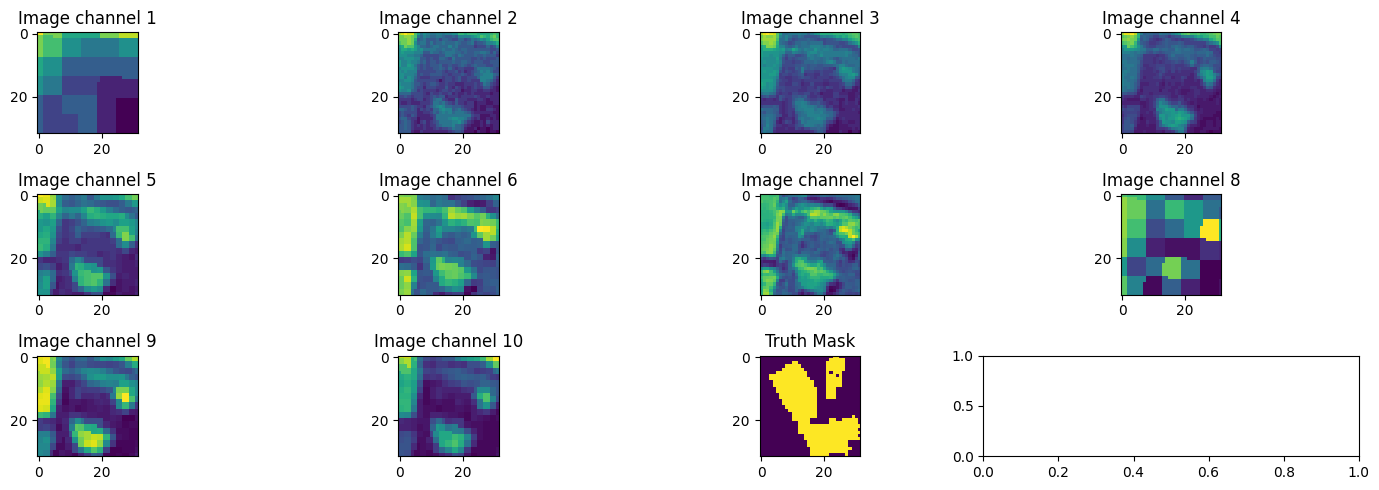

In [ ]:
def visualize(image, mask):
  fig, axs = plt.subplots(3, 4, figsize=(15, 5))
  axs[0][0].imshow(image[:, :, 0])
  axs[0][0].set_title('Image channel 1')
  axs[0][1].imshow(image[:, :, 1])
  axs[0][1].set_title('Image channel 2')
  axs[0][2].imshow(image[:, :, 2])
  axs[0][2].set_title('Image channel 3')
  axs[0][3].imshow(image[:, :, 3])
  axs[0][3].set_title('Image channel 4')
  axs[1][0].imshow(image[:, :, 4])
  axs[1][0].set_title('Image channel 5')
  axs[1][1].imshow(image[:, :, 5])
  axs[1][1].set_title('Image channel 6')
  axs[1][2].imshow(image[:, :, 6])
  axs[1][2].set_title('Image channel 7')
  axs[1][3].imshow(image[:, :, 7])
  axs[1][3].set_title('Image channel 8')
  axs[2][0].imshow(image[:, :, 8])
  axs[2][0].set_title('Image channel 9')
  axs[2][1].imshow(image[:, :, 9])
  axs[2][1].set_title('Image channel 10')

  axs[2][2].imshow(mask)
  axs[2][2].set_title('Truth Mask')

  plt.tight_layout()
  plt.show()
  plt.close(fig)

visualize(train_images_batch[11], train_masks_batch[11])

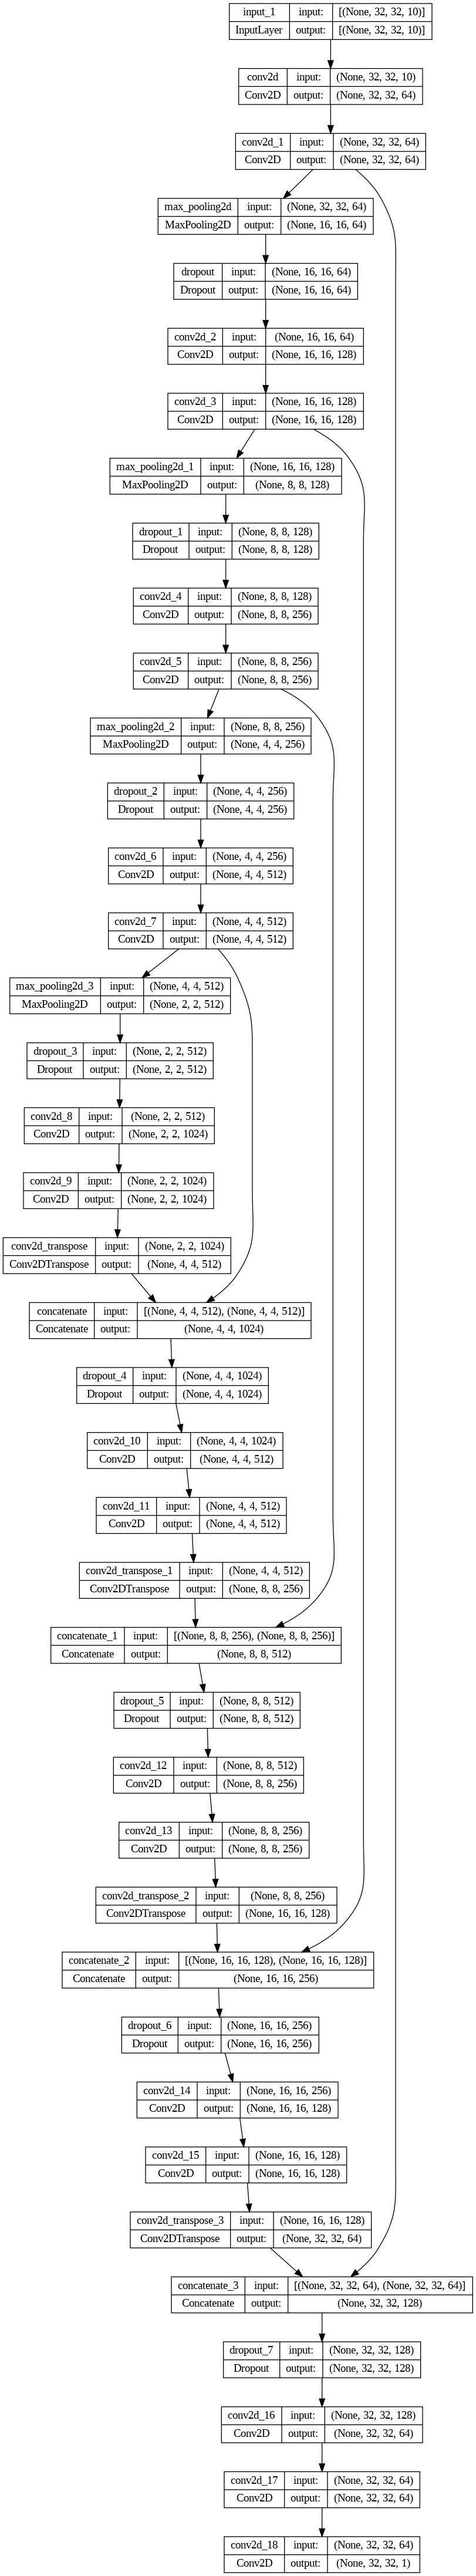

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
def double_conv_block(x, n_filters):

   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

   return x
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)

   return f, p
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)

   return x
def build_unet_model():
 # inputs
   inputs = layers.Input(shape=(32,32,10))

   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)

   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)

   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)

   # outputs
   outputs = layers.Conv2D(1, 1, padding="same", activation = "sigmoid")(u9)

   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

   return unet_model
unet_model = build_unet_model()
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses
                   .BinaryFocalCrossentropy(apply_class_balancing=True, alpha=0.9,gamma=2, from_logits=False),
                  metrics="accuracy")
plot_model(unet_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
#tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True, alpha=0.9,gamma=2, from_logits=False),

In [ ]:
epoch = 500
batch_size = 20
weights = [0.30, 0.70]

train_images, val_images, train_masks, val_masks = train_test_split(transformed_images_train,
                                                                    transformed_masks_train,
                                                                    test_size=0.2, random_state=42)
def add_sample_weights(label,weights):
    # The weights for each class, with the constraint that:
    #     sum(class_weights) == 1.0
    class_weights = tf.constant(weights)
    class_weights = class_weights / tf.reduce_sum(class_weights)
    # Create an image of `sample_weights` by using the label at each pixel as an
    # index into the `class weights` .
    sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))
    return sample_weights

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=200,
    restore_best_weights=True
)
#sample_weight=add_sample_weights(train_masks,weights),
unet_model.fit(train_images, train_masks, epochs=epoch, batch_size=batch_size,
          callbacks=[early_stopping],
          validation_data=(val_images, val_masks))

Epoch 1/500
151/151 [==============================] - 28s 88ms/step - loss: 0.0256 - accuracy: 0.9286 - val_loss: 0.0269 - val_accuracy: 0.9272
Epoch 2/500
151/151 [==============================] - 10s 67ms/step - loss: 0.0256 - accuracy: 0.9330 - val_loss: 0.0269 - val_accuracy: 0.9272
Epoch 3/500
151/151 [==============================] - 11s 70ms/step - loss: 0.0255 - accuracy: 0.9342 - val_loss: 0.0268 - val_accuracy: 0.9272
Epoch 4/500
151/151 [==============================] - 10s 69ms/step - loss: 0.0255 - accuracy: 0.9303 - val_loss: 0.0268 - val_accuracy: 0.9272
Epoch 5/500
151/151 [==============================] - 10s 65ms/step - loss: 0.0255 - accuracy: 0.9343 - val_loss: 0.0268 - val_accuracy: 0.9272
Epoch 6/500
151/151 [==============================] - 10s 65ms/step - loss: 0.0255 - accuracy: 0.9329 - val_loss: 0.0270 - val_accuracy: 0.9272
Epoch 7/500
151/151 [==============================] - 10s 65ms/step - loss: 0.0255 - accuracy: 0.9299 - val_loss: 0.0268 - val_ac

In [ ]:

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_recall_fscore_support


predicted_masks = unet_model.predict(transformed_images_test)
predicted_masks = (predicted_masks > 0.5).astype(np.uint8)
true_masks = transformed_masks_test.flatten()
pred_masks = predicted_masks.flatten()

print("============================================================================")
print("Prediction : TEST \n")
print("Evaluation Metrics:")
print("Precision:", precision_score(true_masks, pred_masks, zero_division=0))
print("Recall:", recall_score(true_masks, pred_masks, zero_division=0))
print("F1-score:", f1_score(true_masks, pred_masks, zero_division=0))
print("Mean IoU:", jaccard_score(true_masks, pred_masks, average='macro'))
print("Confusion Matrix:\n", confusion_matrix(true_masks, pred_masks))
metrics = precision_recall_fscore_support(true_masks.ravel(), pred_masks.ravel(), zero_division=0 ,average=None)
print("precision_attacchi: ", metrics[1][1])
print("precision_normali: ", metrics[1][0])
print("F1 attacchi:", metrics[2][1])
print("F1 normali:", metrics[2][0])
print("Macro F1:", metrics[2].mean())
print("OA:", accuracy_score(true_masks, pred_masks))


predicted_masks = unet_model.predict(transformed_images_train)
predicted_masks = (predicted_masks > 0.5).astype(np.uint8)
true_masks = transformed_masks_train.flatten()
pred_masks = predicted_masks.flatten()

print("============================================================================")
print("Prediction : TRAIN \n")
print("Evaluation Metrics:")
print("Precision:", precision_score(true_masks, pred_masks, zero_division=0))
print("Recall:", recall_score(true_masks, pred_masks, zero_division=0))
print("F1-score:", f1_score(true_masks, pred_masks, zero_division=0))
print("Mean IoU:", jaccard_score(true_masks, pred_masks, average='macro'))
print("Confusion Matrix:\n", confusion_matrix(true_masks, pred_masks))
metrics = precision_recall_fscore_support(true_masks.ravel(), pred_masks.ravel(), zero_division=0 ,average=None)
print("precision_attacchi: ", metrics[1][1])
print("precision_normali: ", metrics[1][0])
print("F1 attacchi:", metrics[2][1])
print("F1 normali:", metrics[2][0])
print("Macro F1:", metrics[2].mean())
print("OA:", accuracy_score(true_masks, pred_masks))



6/6 [==============================] - 2s 128ms/step
Prediction : TEST 

Evaluation Metrics:
Precision: 0.01699001262771209
Recall: 0.26772793053545585
F1-score: 0.031952330577085
Mean IoU: 0.37151678891467443
Confusion Matrix:
 [[119285  42815]
 [  2024    740]]
precision_attacchi:  0.26772793053545585
precision_normali:  0.7358729179518816
F1 attacchi: 0.031952330577085
F1 normali: 0.8417869580711974
Macro F1: 0.4368696443241412
OA: 0.728024310947205
118/118 [==============================] - 2s 20ms/step
Prediction : TRAIN 

Evaluation Metrics:
Precision: 0.12242909228325297
Recall: 0.27035516011760113
F1-score: 0.16853698510047213
Mean IoU: 0.45478458161861995
Confusion Matrix:
 [[3093886  501609]
 [ 188862   69979]]
precision_attacchi:  0.27035516011760113
precision_normali:  0.8604895848833054
F1 attacchi: 0.16853698510047213
F1 normali: 0.8996152069649183
Macro F1: 0.5340760960326952
OA: 0.8208586381675079


In [ ]:
unet_model.save("26_70.h5")